# Lasso Scenario Creation Quickstart

In this notebook we will run through:

1. Using a configuration file to run lasso  
2. Setting up a base scenario and applying projects  
3. Transforming the standard network format to the MetCouncil expected format    
4. Exporting the network to a shapefile and csvs  

In [1]:
import os
import sys
import yaml

import pandas as pd

from network_wrangler import RoadwayNetwork
from network_wrangler import TransitNetwork
from network_wrangler import ProjectCard
from network_wrangler import Scenario
from network_wrangler import WranglerLogger

from lasso import ModelRoadwayNetwork
from lasso import StandardTransit

In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
import logging
logger = logging.getLogger("WranglerLogger")
logger.handlers[0].stream = sys.stdout
# if you don't want to see so much detail, set to logging.INFO or DEBUG
logger.setLevel(logging.DEBUG)

## Read a Config File

Let's examine the configuration file and store it as `my_config` variable.  

Configuration files are written in YAML and read in as python dictionaries.

In [4]:
MY_CONFIG_FILE = "C:/projects/met_council_git/project_cards/settings/i394e_ml_test.yaml"

with open(MY_CONFIG_FILE) as f:
        my_config = yaml.safe_load(f)
        
import json
print(json.dumps(my_config, indent=2))

## Alternatively this could be written in the notebook our selected via a notebook GUI

{
  "base_scenario": {
    "input_dir": "C:/projects/met_council_git/data/interim/networks/base_network",
    "shape_file_name": "shape.geojson",
    "link_file_name": "link.json",
    "node_file_name": "node.geojson",
    "transit_directory": "",
    "validate_network": false
  },
  "scenario": {
    "project_cards_filenames": [
      "C:/projects/met_council_git/project_cards/test/i394E_parallel_managed_lane.yml"
    ],
    "card_directory": "C:/projects/met_council_git/project_cards/test/",
    "glob_search": [],
    "tags": []
  },
  "output": {
    "format": "geojson",
    "directory": "",
    "prefix": ""
  }
}


## Create a Base Scenario

Base scenarios must at the least specify a highway network but can also specify a directory where transit networks can be found.  

In this step the highway and transit networks are read in and validated to each other.  

In some cases, you may want to override the validation (after reviewing the errors) using the flag: `validate = False`.

In [5]:
base_wrangler_path = os.path.join(os.path.dirname((os.path.dirname(os.path.abspath('')))),"network_wrangler")
WranglerLogger.info("Base Wrangler Path: {}".format(base_wrangler_path))

base_scenario = Scenario.create_base_scenario(
        my_config["base_scenario"]["shape_file_name"],
        my_config["base_scenario"]["link_file_name"],
        my_config["base_scenario"]["node_file_name"],
        roadway_dir=my_config["base_scenario"]["input_dir"],
        transit_dir=my_config["base_scenario"]["input_dir"],
        validate = False
    )

2020-04-16 12:03:14, INFO: Base Wrangler Path: d:\network_wrangler
2020-04-16 12:03:14, INFO: Reading from following files:
-C:/projects/met_council_git/data/interim/networks/base_network\link.json
-C:/projects/met_council_git/data/interim/networks/base_network\node.geojson
-C:/projects/met_council_git/data/interim/networks/base_network\shape.geojson.
2020-04-16 12:07:01, INFO: Read 1133676 links from C:/projects/met_council_git/data/interim/networks/base_network\link.json
2020-04-16 12:07:01, INFO: Read 354346 nodes from C:/projects/met_council_git/data/interim/networks/base_network\node.geojson
2020-04-16 12:07:01, INFO: Read 1133676 shapes from C:/projects/met_council_git/data/interim/networks/base_network\shape.geojson
2020-04-16 12:11:52, INFO: Read in transit feed from: C:/projects/met_council_git/data/interim/networks/base_network
2020-04-16 12:11:52, DEBUG: ...agency.txt:
  agency_id       agency_name                   agency_url  agency_timezone  \
0         0     Metro Transi

2020-04-16 12:11:52, DEBUG: ...frequencies.txt:
                             trip_id  headway_secs  start_time  end_time
0  14940701-JUN19-MVS-BUS-Weekday-01          3600     21600.0   32400.0
1  14941148-JUN19-MVS-BUS-Weekday-01           830     21600.0   32400.0
2  14941151-JUN19-MVS-BUS-Weekday-01           540     21600.0   32400.0
3  14941153-JUN19-MVS-BUS-Weekday-01           696     32400.0   54000.0
4  14941163-JUN19-MVS-BUS-Weekday-01           830     32400.0   54000.0
5  14941643-JUN19-MVS-BUS-Weekday-01           900     21600.0   32400.0
6  14941652-JUN19-MVS-BUS-Weekday-01          1200     32400.0   54000.0
7  14942968-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
8  14943414-JUN19-MVS-BUS-Weekday-01          2160     21600.0   32400.0
9  14943415-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
2020-04-16 12:11:52, DEBUG: ...shapes.txt:
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence shape_osm_node_id  \
0  4520004     44.923257   

2020-04-16 12:11:53, DEBUG: starting ox_graph()
2020-04-16 12:11:53, DEBUG: GRAPH NODES: Index(['model_node_id', 'osm_node_id', 'shstReferenceId', 'transit_node',
       'drive_node', 'walk_node', 'bike_node', 'geometry', 'x', 'y'],
      dtype='object')
2020-04-16 12:11:54, DEBUG: starting ox.gdfs_to_graph()
2020-04-16 12:15:45, DEBUG: finished ox.gdfs_to_graph()


#### Create project cards from projects that are explicitely specified in config


In [6]:

if len(my_config["scenario"]["project_cards_filenames"]) > 0:
    project_cards_list = [
        ProjectCard.read(filename, validate=False)
        for filename in my_config["scenario"]["project_cards_filenames"]
    ]
else: 
    project_cards_list = []
project_cards_list


## Create Scenario

A scenario is constructed with a base scenario and then selecting project cards to be added to that base scenario to create the new scenario.

Projects can be added a variety of ways:

 1. `card_directory` + `tags` will search a directory add project's who's project tags match *at least one of* the tags in the keyword.
 2. `card_directory` + `glob_search` will search a directory add project's who's file name matches the [glob search text](https://docs.python.org/3/library/glob.html)
 3. `project_cards_list` is a list of ProjectCard objects
 
Optionally, you may specify that project card formats are not validated by setting they keyword: 
   `validate = False`
   
Projects that are not added in the initial scenario development can be added by using the following methods:  

 - `add_project_card_from_file()`  
 - `add_project_cards_from_directory()`  
 - `add_project_cards_from_tags`
 
Or by directly adding the project to the scenario's project attribute by running:

```python
my_project = ProjectCard.read(path_to_card)
my_scenario.projects += my_project

```


In [7]:
my_scenario=None

my_scenario = Scenario.create_scenario(
    base_scenario=base_scenario,
    project_cards_list=project_cards_list,
    validate_project_cards=False,
)

2020-04-16 12:15:46, INFO: Creating Scenario
2020-04-16 12:15:46, DEBUG: Adding project cards from List.
I394 Parallel Lanes


### Apply all projects in scenario

In [8]:
WranglerLogger.info("\nProjects in queue to be applied: \n - {}".format("\n - ".join(my_scenario.get_project_names())))
WranglerLogger.info("\n[Before] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

my_scenario.apply_all_projects()

WranglerLogger.info("\n[After] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

2020-04-16 12:17:41, INFO: 
Projects in queue to be applied: 
 - I394 Parallel Lanes
2020-04-16 12:17:41, INFO: 
[Before] Applied Projects: 
 - 
2020-04-16 12:17:41, DEBUG: Ordered Project Cards: {'i394 parallel lanes': <network_wrangler.projectcard.ProjectCard object at 0x00000204AC7925C8>}
2020-04-16 12:17:41, DEBUG: Project Cards: [<network_wrangler.projectcard.ProjectCard object at 0x00000204AC7925C8>]
2020-04-16 12:17:41, INFO: Applying I394 Parallel Lanes
2020-04-16 12:17:41, INFO: Applying Project to Roadway Network: I394 Parallel Lanes
2020-04-16 12:17:41, DEBUG: validating selection
2020-04-16 12:17:41, DEBUG: Selection Key: ((model_link_id==416366 or model_link_id==414813 or model_link_id==381248 or model_link_id==381223 or model_link_id==417878 or model_link_id==418556 or model_link_id==418512 or model_link_id==419032 or model_link_id==419044 or model_link_id==419040 or model_link_id==419637 or model_link_id==419634 or model_link_id==417947 or model_link_id==420448 or model_

d:\network_wrangler\network_wrangler\roadwaynetwork.py:846: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_links["i"] = 0


2020-04-16 12:17:42, INFO: 
[After] Applied Projects: 
 - I394 Parallel Lanes


In [9]:
my_scenario.road_net.links_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1133676 entries, 0 to 1133675
Data columns (total 36 columns):
model_link_id         1133676 non-null int64
osm_link_id           1133676 non-null object
shstReferenceId       1133676 non-null object
shstGeometryId        1133676 non-null object
u                     1133676 non-null object
v                     1133676 non-null object
A                     1133676 non-null int64
B                     1133676 non-null int64
locationReferences    1133676 non-null object
distance              1133676 non-null float64
roadway               1133676 non-null object
name                  1133676 non-null object
ref                   1133676 non-null object
bridge                1133676 non-null object
tunnel                1133676 non-null object
width                 1133676 non-null object
max_speed             1133676 non-null object
bike_facility         1133676 non-null int64
transit_access        1133676 non-null int64
drive_acc

In [10]:
my_scenario.road_net.links_df[my_scenario.road_net.links_df["segment_id"] == 5]

,model_link_id,osm_link_id,shstReferenceId,shstGeometryId,u,v,A,B,locationReferences,distance,...,trn_priority,ttime_assert,geometry,managed,ML_lanes,segment_id,ML_HOV,HOV,ML_access,ML_egress
381222,381223,638885526,34557a79200bf71e4d90d3b289b864e1,85d1b20a788de50780718ce31ca2e9d1,538452217,540475529,3635,156008,"[{'sequence': 1, 'point': [-93.4869879, 44.970...",0.348031,...,0,0.0,"LINESTRING (-93.48699 44.97093, -93.47989 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
381247,381248,"638885528,307996843,118924102",a20afc1891bf6aa5c7058d5b2e5282e8,428f7001fd947b0a9add231a6b06a68c,538453317,538452217,3755,3635,"[{'sequence': 1, 'point': [-93.4965751, 44.973...",0.542095,...,0,0.0,"LINESTRING (-93.49658 44.97388, -93.48699 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
394056,394057,638885573,9776ac3f22e7dde83e6c86e455e8500c,a241e100d0183672b251ce47aa9be81a,558552619,558552645,53546,53554,"[{'sequence': 1, 'point': [-93.3652207, 44.971...",0.179108,...,0,0.0,"LINESTRING (-93.36522 44.97124, -93.36160 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
414812,414813,118924102,3bd6e4f817bb5126f94198f206b65cba,55c1e370091c2e615b8fb0d9e63e06a4,540421494,538453317,142318,3755,"[{'sequence': 1, 'point': [-93.5075969, 44.975...",0.581543,...,0,0.0,"LINESTRING (-93.50760 44.97598, -93.49658 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
416365,416366,118924102,a4c400a5bf1e62ddf997436279f56d51,65dc2cbfada8a6036b6e47dc1ddd3cde,540450160,540421494,149137,142318,"[{'sequence': 1, 'point': [-93.5266217, 44.976...",0.978881,...,0,0.0,"LINESTRING (-93.52662 44.97665, -93.50760 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
417877,417878,"307996844,42849980",be263dc95c9f6a87c6507fa8081cfe20,9b88470bb8b2ef7d5f6057885bcd2a24,540475529,540489911,156008,159999,"[{'sequence': 1, 'point': [-93.4798852, 44.970...",1.235032,...,0,0.0,"LINESTRING (-93.47989 44.97094, -93.45469 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
417946,417947,"42864197,307996845,307996847",c364d61001c794586443b3237d7882aa,4c3f1cd370f85e80cdbc526df1fe9145,536282483,567258489,156390,167859,"[{'sequence': 1, 'point': [-93.4107121, 44.972...",1.464447,...,0,0.0,"LINESTRING (-93.41071 44.97289, -93.38152 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
418511,418512,120633502,53c224b3d81ef535d84b5e4ad5bb1cd8,7901a1b08e617827af821de9af3b81fe,540489251,540499823,159823,162092,"[{'sequence': 1, 'point': [-93.4517692, 44.970...",0.112350,...,0,0.0,"LINESTRING (-93.45177 44.97089, -93.44948 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
418555,418556,120633502,ba4c826926fcaa118f6052effd54e91d,4fe02f816dd990c17dfeb8d1368cf9d0,540489911,540489251,159999,159823,"[{'sequence': 1, 'point': [-93.4546872, 44.970...",0.142984,...,0,0.0,"LINESTRING (-93.45469 44.97090, -93.45177 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
419031,419032,120633502,e8e4a8e23cfbe30e3f9adc1f570dbbd1,04ebb6f855058f2a096a64fcf360820c,540499823,540500005,162092,162142,"[{'sequence': 1, 'point': [-93.4494763, 44.970...",0.610506,...,0,0.0,"LINESTRING (-93.44948 44.97089, -93.43702 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all


# Write out as MetCouncil Model Roadway Network
Everything above was done in "pure wrangler" rather than lasso.  However, we will need Lasso in order to add the MetCouncil specific variables. You can create a lasso ModelRoadwayNetwork object from the roadway network object and feed it any additional parameters from that `my_config` variable.

You can see that the link variables for this network are the same as the standard roadway network at this point but that will change.

Since this is a GeoDataFrame you can also use build-in Geopandas features to make simple plots based on these variables.

In [11]:
model_road_net = ModelRoadwayNetwork.from_RoadwayNetwork(
    my_scenario.road_net, parameters=my_config.get("my_parameters", {})
)

2020-04-16 12:22:40, INFO: Lasso base directory set as: d:\lasso


In [12]:
model_road_net.links_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1133676 entries, 0 to 1133675
Data columns (total 36 columns):
model_link_id         1133676 non-null int64
osm_link_id           1133676 non-null object
shstReferenceId       1133676 non-null object
shstGeometryId        1133676 non-null object
u                     1133676 non-null object
v                     1133676 non-null object
A                     1133676 non-null int64
B                     1133676 non-null int64
locationReferences    1133676 non-null object
distance              1133676 non-null float64
roadway               1133676 non-null object
name                  1133676 non-null object
ref                   1133676 non-null object
bridge                1133676 non-null object
tunnel                1133676 non-null object
width                 1133676 non-null object
max_speed             1133676 non-null object
bike_facility         1133676 non-null int64
transit_access        1133676 non-null int64
drive_acc

In [13]:
model_road_net.links_df.loc[model_road_net.links_df["HOV"] == "NaN", "HOV"] = "0"

In [14]:
pd.options.display.max_columns = None

In [15]:
model_road_net.links_df[model_road_net.links_df["HOV"] != "0"]

,model_link_id,osm_link_id,shstReferenceId,shstGeometryId,u,v,A,B,locationReferences,distance,roadway,name,ref,bridge,tunnel,width,max_speed,bike_facility,transit_access,drive_access,walk_access,bike_access,truck_access,lanes,access,price,trn_priority,ttime_assert,geometry,managed,ML_lanes,segment_id,ML_HOV,HOV,ML_access,ML_egress
381222,381223,638885526,34557a79200bf71e4d90d3b289b864e1,85d1b20a788de50780718ce31ca2e9d1,538452217,540475529,3635,156008,"[{'sequence': 1, 'point': [-93.4869879, 44.970...",0.348031,motorway,,US 12,,,,65 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.48699 44.97093, -93.47989 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
381247,381248,"638885528,307996843,118924102",a20afc1891bf6aa5c7058d5b2e5282e8,428f7001fd947b0a9add231a6b06a68c,538453317,538452217,3755,3635,"[{'sequence': 1, 'point': [-93.4965751, 44.973...",0.542095,motorway,,US 12,yes,,,65 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.49658 44.97388, -93.48699 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
394056,394057,638885573,9776ac3f22e7dde83e6c86e455e8500c,a241e100d0183672b251ce47aa9be81a,558552619,558552645,53546,53554,"[{'sequence': 1, 'point': [-93.3652207, 44.971...",0.179108,motorway,,I 394,,,,55 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.36522 44.97124, -93.36160 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
414812,414813,118924102,3bd6e4f817bb5126f94198f206b65cba,55c1e370091c2e615b8fb0d9e63e06a4,540421494,538453317,142318,3755,"[{'sequence': 1, 'point': [-93.5075969, 44.975...",0.581543,motorway,,US 12,,,,65 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.50760 44.97598, -93.49658 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
416365,416366,118924102,a4c400a5bf1e62ddf997436279f56d51,65dc2cbfada8a6036b6e47dc1ddd3cde,540450160,540421494,149137,142318,"[{'sequence': 1, 'point': [-93.5266217, 44.976...",0.978881,motorway,,US 12,,,,65 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.52662 44.97665, -93.50760 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
417877,417878,"307996844,42849980",be263dc95c9f6a87c6507fa8081cfe20,9b88470bb8b2ef7d5f6057885bcd2a24,540475529,540489911,156008,159999,"[{'sequence': 1, 'point': [-93.4798852, 44.970...",1.235032,motorway,,US 12,,,,"55 mph,65 mph",0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.47989 44.97094, -93.45469 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
417946,417947,"42864197,307996845,307996847",c364d61001c794586443b3237d7882aa,4c3f1cd370f85e80cdbc526df1fe9145,536282483,567258489,156390,167859,"[{'sequence': 1, 'point': [-93.4107121, 44.972...",1.464447,motorway,,I 394,yes,,,55 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.41071 44.97289, -93.38152 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
418511,418512,120633502,53c224b3d81ef535d84b5e4ad5bb1cd8,7901a1b08e617827af821de9af3b81fe,540489251,540499823,159823,162092,"[{'sequence': 1, 'point': [-93.4517692, 44.970...",0.112350,motorway,,I 394,,,,55 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.45177 44.97089, -93.44948 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
418555,418556,120633502,ba4c826926fcaa118f6052effd54e91d,4fe02f816dd990c17dfeb8d1368cf9d0,540489911,540489251,159999,159823,"[{'sequence': 1, 'point': [-93.4546872, 44.970...",0.142984,motorway,,I 394,,,,55 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.45469 44.97090, -93.45177 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all
419031,419032,120633502,e8e4a8e23cfbe30e3f9adc1f570dbbd1,04ebb6f855058f2a096a64fcf360820c,540499823,540500005,162092,162142,"[{'sequence': 1, 'point': [-93.4494763, 44.970...",0.610506,motorway,,I 394,,,,55 mph,0,0,1,0,0,1,3,,0,0,0.0,"LINESTRING (-93.44948 44.97089, -93.43702 44.9...",1,"{'default': 0, 'timeofday': [{'time': (21600, ...",5,5,5,all,all


In [16]:
model_road_net.nodes_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 354346 entries, 1 to 354385
Data columns (total 12 columns):
model_node_id           354346 non-null int64
osm_node_id             354346 non-null object
shstReferenceId         354346 non-null object
transit_node            354346 non-null int64
drive_node              354346 non-null int64
walk_node               354346 non-null int64
bike_node               354346 non-null int64
outboundReferenceIds    354346 non-null object
inboundReferenceIds     354346 non-null object
geometry                354346 non-null geometry
x                       354346 non-null float64
y                       354346 non-null float64
dtypes: float64(2), geometry(1), int64(5), object(4)
memory usage: 35.1+ MB


## Add MetCouncil variables
At this point, we need to calculate all the variables into what MetCouncil's model is expecting. The method `roadway_standard_to_met_council_network()` broadly does the following:  
 
- creates a parallel managed lane network
- calculates additional variables based on geography or other variables (i.e. county, assignment group, area type, etc)
- flattens variables stored as continuous time values and determines their value by time period (i.e. lanes_am)   
- reprojects into MetCouncil's projection

In [17]:
model_road_net.roadway_standard_to_met_council_network()

2020-04-16 12:22:45, INFO: Renaming roadway attributes to be consistent with what metcouncil's model is expecting
2020-04-16 12:22:45, INFO: Creating managed lane network.
2020-04-16 12:22:45, INFO: Creating network with duplicated managed lanes


d:\network_wrangler\network_wrangler\roadwaynetwork.py:1770: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_links_df[attr] = ""
d:\network_wrangler\network_wrangler\roadwaynetwork.py:1764: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_links_df[gp_attr] = ml_links_df[attr]
C:\Anaconda3\envs\lasso_env\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior

2020-04-16 12:23:39, INFO: Creating calculated roadway variables.
2020-04-16 12:23:39, INFO: Calculating Area Type from Spatial Data and adding as roadway network variable: area_type
2020-04-16 12:23:51, DEBUG: Reading Area Type Shapefile d:\lasso\metcouncil_data\area_type\ThriveMSP2040CommunityDesignation.shp


C:\Anaconda3\envs\lasso_env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\lasso_env\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


2020-04-16 12:25:28, DEBUG: Area Type Codes Used: {23: 4, 24: 3, 25: 2, 35: 2, 36: 1, 41: 1, 51: 1, 52: 1, 53: 1, 60: 1}
2020-04-16 12:25:28, INFO: Finished Calculating Area Type from Spatial Data into variable: area_type
2020-04-16 12:25:31, INFO: Adding roadway network variable for county using a spatial join with: d:\lasso\metcouncil_data\county\cb_2017_us_county_5m.shp


C:\Anaconda3\envs\lasso_env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\lasso_env\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


2020-04-16 12:27:10, INFO: Finished Calculating county variable: county
2020-04-16 12:27:13, INFO: Calculating Centroid Connector and adding as roadway network variable: centroidconnect
2020-04-16 12:27:13, DEBUG: Calculating Centroid Connectors using highest TAZ number: 3100
2020-04-16 12:27:14, INFO: Finished calculating centroid connector variable: centroidconnect
2020-04-16 12:27:14, INFO: Calculating MPO as roadway network variable: mpo
2020-04-16 12:27:14, DEBUG: MPO Counties: ANOKA,DAKOTA,HENNEPIN,RAMSEY,SCOTT,WASHINGTON,CARVER
2020-04-16 12:27:14, INFO: Finished calculating MPO variable: mpo
2020-04-16 12:27:14, INFO: Calculating Assignment Group as network variable: assign_group
2020-04-16 12:27:14, DEBUG: Calculating Centroid Connectors
2020-04-16 12:27:14, INFO: Centroid Connector Variable 'centroidconnect' already in network. Returning without overwriting.
2020-04-16 12:27:14, DEBUG: Reading MRCC / Shared Streets Match CSV
2020-04-16 12:27:14, DEBUG: Reading MRCC Shapefile:

C:\Anaconda3\envs\lasso_env\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2020-04-16 12:27:19, DEBUG: MRCC GDF Columns
Index(['LINK_ID', 'ROUTE_SYS', 'ST_CONCAT', 'geometry'], dtype='object')
2020-04-16 12:27:20, DEBUG: mrcc shst ref df columns
Index(['shstReferenceId', 'shstGeometryId', 'pp_link_id', 'score'], dtype='object')
2020-04-16 12:27:27, DEBUG: WiDOT GDF Columns
Index(['OBJECTID', 'WISLR_OVLY', 'SURF_TYCD', 'TRLNS_SURF', 'TRLNS_SU_1',
       'LSHD_SURF_', 'LEFT_SHLD_', 'RSHD_SURF_', 'RGHT_SHLD_', 'RDWY_OWRST',
       'RW_INDC', 'RW_WD', 'MEDN_TYCD', 'LEFT_CURB_', 'RGHT_CURB_',
       'PRKG_TYCD', 'TRLNS_NB', 'WISLR_SFRT', 'SDWK_TYCD', 'HARST_TYCD',
       'VARST_TYCD', 'RDWY_MAGMT', 'RDWY_MAG_1', 'LOC_WISLR_', 'RWCRT_MILG',
       'RDWY_CTGY_', 'RDWY_SBCTG', 'AVG_DLY_TR', 'AVG_DLY__1', 'AVG_DLY__2',
       'RDWY_ACS_T', 'FED_URLC_T', 'FEDUA_TYCD', 'FED_CLSN_T', 'FNCT_CLS_T',
       'NHS_CLS_TY', 'NHS_RTE_NB', 'HPMS_SMPL_', 'HOV_LANE_T', 'PVMT_IRI_N',
       'PVMT_IRI_Y', 'ST_LABL_NM', 'ST_PRMY_SY', 'RDWY_LINK_', 'SHC_NTWK_N',
       'WISLR_PTY_', '

d:\lasso\lasso\roadway.py:929: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ].astype(network_var_type)


2020-04-16 12:29:53, INFO: Finished adding counts variable: AADT
2020-04-16 12:29:53, INFO: Finished creating ML lanes variable: ML_lanes
2020-04-16 12:29:53, INFO: Hov corridor Variable 'segment_id' already in network. Returning without overwriting.
2020-04-16 12:29:53, INFO: Filling nan for network from network wrangler
2020-04-16 12:30:26, INFO: Converting variable type to MetCouncil standard
2020-04-16 12:30:27, INFO: Splitting variables by time period and category
2020-04-16 12:31:05, INFO: Setting Coordinate Reference System to EPSG 26915


C:\Anaconda3\envs\lasso_env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\lasso_env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\lasso_env\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [18]:
model_road_net.links_metcouncil_df.query('lanes == 0 & drive_access == 1 & centroidconnect')

,A,B,HOV,access,bike_access,bike_facility,bridge,distance,drive_access,egress,geometry,lanes,locationReferences,managed,max_speed,model_link_id,name,osm_link_id,price,ref,roadway,segment_id,shstGeometryId,shstReferenceId,transit_access,trn_priority,truck_access,ttime_assert,tunnel,u,v,walk_access,width,area_type,county,centroidconnect,mpo,assign_group,roadway_class,AADT,count_AM,count_MD,count_PM,count_NT,count_daily,count_year,ML_lanes,trn_priority_AM,trn_priority_MD,trn_priority_PM,trn_priority_NT,ttime_assert_AM,ttime_assert_MD,ttime_assert_PM,ttime_assert_NT,lanes_AM,lanes_MD,lanes_PM,lanes_NT,ML_lanes_AM,ML_lanes_MD,ML_lanes_PM,ML_lanes_NT,price_sov_AM,price_hov2_AM,price_hov3_AM,price_truck_AM,price_sov_MD,price_hov2_MD,price_hov3_MD,price_truck_MD,price_sov_PM,price_hov2_PM,price_hov3_PM,price_truck_PM,price_sov_NT,price_hov2_NT,price_hov3_NT,price_truck_NT,access_AM,access_MD,access_PM,access_NT
1078668,1,6913,0,,0,0,,0.0,1,,"LINESTRING (462454.756 5027410.345, 463975.146...",0,"[{'sequence': 1, 'point': [-93.4797129169, 45....",0,,1134079,,,0,,,0,,,0,0,1,0.0,,1,186165180,0,,1,1,1,0,9,0,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1078671,1,10371,0,,0,0,,0.0,1,,"LINESTRING (462454.756 5027410.345, 464100.533...",0,"[{'sequence': 1, 'point': [-93.4797129169, 45....",0,,1134082,,,0,,,0,,,0,0,1,0.0,,1,186182354,0,,1,1,1,0,9,0,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1078675,1,28667,0,,0,0,,0.0,1,,"LINESTRING (462454.756 5027410.345, 463976.952...",0,"[{'sequence': 1, 'point': [-93.4797129169, 45....",0,,1134086,,,0,,,0,,,0,0,1,0.0,,1,186249448,0,,1,1,1,0,9,0,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1078676,1,46064,0,,0,0,,0.0,1,,"LINESTRING (462454.756 5027410.345, 463983.549...",0,"[{'sequence': 1, 'point': [-93.4797129169, 45....",0,,1134087,,,0,,,0,,,0,0,1,0.0,,1,186293617,0,,1,1,1,0,9,0,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1078677,10,13589,0,,1,0,,0.0,1,,"LINESTRING (478413.092 5024938.192, 477611.300...",0,"[{'sequence': 1, 'point': [-93.2757094362, 45....",0,,1134088,,,0,,,0,,,0,0,1,0.0,,10,186199316,1,,1,1,1,0,9,0,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133663,998,26834,0,,0,0,,0.0,1,,"LINESTRING (463183.125 4981941.133, 462827.193...",0,"[{'sequence': 1, 'point': [-93.4670469803, 44....",0,,1189074,,,0,,,0,,,0,0,1,0.0,,998,34199393,0,,2,4,1,0,9,99,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1133670,999,113283,0,,0,0,,0.0,1,,"LINESTRING (462383.024 4981543.226, 462134.338...",0,"[{'sequence': 1, 'point': [-93.477166737, 44.9...",0,,1189081,,,0,,,0,,,0,0,1,0.0,,999,33347951,0,,2,4,1,0,9,99,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1133671,999,113285,0,,0,0,,0.0,1,,"LINESTRING (462383.024 4981543.226, 462062.753...",0,"[{'sequence': 1, 'point': [-93.477166737, 44.9...",0,,1189082,,,0,,,0,,,0,0,1,0.0,,999,33347957,0,,2,4,1,0,9,99,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,
1133674,999,150188,0,,0,0,,0.0,1,,"LINESTRING (462383.024 4981543.226, 462060.540...",0,"[{'sequence': 1, 'point': [-93.477166737, 44.9...",0,,1189085,,,0,,,0,,,0,0,1,0.0,,999,34514695,0,,2,4,1,0,9,99,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,


In [19]:
pd.options.display.max_columns = None
model_road_net.links_metcouncil_df[model_road_net.links_metcouncil_df["model_link_id"] == 1390975]["segment_id"]


Series([], Name: segment_id, dtype: int32)

In [20]:
model_road_net.links_metcouncil_df[model_road_net.links_metcouncil_df.model_link_id.isin([390975])]

,A,B,HOV,access,bike_access,bike_facility,bridge,distance,drive_access,egress,geometry,lanes,locationReferences,managed,max_speed,model_link_id,name,osm_link_id,price,ref,roadway,segment_id,shstGeometryId,shstReferenceId,transit_access,trn_priority,truck_access,ttime_assert,tunnel,u,v,walk_access,width,area_type,county,centroidconnect,mpo,assign_group,roadway_class,AADT,count_AM,count_MD,count_PM,count_NT,count_daily,count_year,ML_lanes,trn_priority_AM,trn_priority_MD,trn_priority_PM,trn_priority_NT,ttime_assert_AM,ttime_assert_MD,ttime_assert_PM,ttime_assert_NT,lanes_AM,lanes_MD,lanes_PM,lanes_NT,ML_lanes_AM,ML_lanes_MD,ML_lanes_PM,ML_lanes_NT,price_sov_AM,price_hov2_AM,price_hov3_AM,price_truck_AM,price_sov_MD,price_hov2_MD,price_hov3_MD,price_truck_MD,price_sov_PM,price_hov2_PM,price_hov3_PM,price_truck_PM,price_sov_NT,price_hov2_NT,price_hov3_NT,price_truck_NT,access_AM,access_MD,access_PM,access_NT
390974,37724,54183,0,,0,0,,0.361214,1,,"LINESTRING (490238.289 4975864.792, 490718.757...",2,"[{'sequence': 1, 'point': [-93.1237182, 44.936...",0,45 mph,390975,,39644205,0,I 35E,motorway,0,7d9a1dcd741e913ca7097dff1573c0a8,c4ddc8f0c2fa7df538c9dd003accfd39,0,0,1,0.0,,187851025,187882846,0,,4,5,0,0,4,60,0,0,0,0,0,0,2017,0,0,0,0,0,0.0,0.0,0.0,0.0,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,,


In [21]:
model_road_net.links_metcouncil_df.ML_lanes.isin([1])

381222     False
381247     False
394056     False
414812     False
416365     False
           ...  
1133671    False
1133672    False
1133673    False
1133674    False
1133675    False
Name: ML_lanes, Length: 1133724, dtype: bool

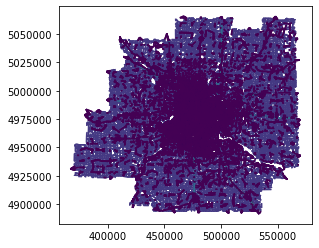

In [22]:
model_road_net.links_metcouncil_df.plot("lanes_AM")

## Export to shapefile

As a last step, the network can be exported to a shapefile and paired CSVs after removing extraneous variables.

(note that this step will also run the `roadway_standard_to_met_council_network()` method but I wanted to show it to you piecewise)

In [23]:
model_road_net.write_roadway_as_shp(
    output_link_shp = "C:/projects/met_council_git/data/interim/networks/fixed_width/link.shp",
    output_node_shp = "C:/projects/met_council_git/data/interim/networks/fixed_width/node.shp"
)

2020-04-16 12:33:46, INFO: Writing Network as Shapefile
2020-04-16 12:33:46, DEBUG: Output Variables: 
 - model_link_id
 - link_id
 - A
 - B
 - shstGeometryId
 - distance
 - roadway
 - name
 - roadway_class
 - bike_access
 - transit_access
 - walk_access
 - drive_access
 - truck_access
 - trn_priority_AM
 - trn_priority_MD
 - trn_priority_PM
 - trn_priority_NT
 - ttime_assert_AM
 - ttime_assert_MD
 - ttime_assert_PM
 - ttime_assert_NT
 - lanes_AM
 - lanes_MD
 - lanes_PM
 - lanes_NT
 - price_sov_AM
 - price_hov2_AM
 - price_hov3_AM
 - price_truck_AM
 - price_sov_MD
 - price_hov2_MD
 - price_hov3_MD
 - price_truck_MD
 - price_sov_PM
 - price_hov2_PM
 - price_hov3_PM
 - price_truck_PM
 - price_sov_NT
 - price_hov2_NT
 - price_hov3_NT
 - price_truck_NT
 - roadway_class_idx
 - assign_group
 - access_AM
 - access_MD
 - access_PM
 - access_NT
 - mpo
 - area_type
 - county
 - centroidconnect
 - AADT
 - count_year
 - count_AM
 - count_MD
 - count_PM
 - count_NT
 - count_daily
 - model_node_id
 

# Export to fixed width file

In [24]:
model_road_net.write_roadway_as_fixedwidth(
    output_link_txt = "C:/projects/met_council_git/data/interim/networks/fixed_width/link.txt",
    output_node_txt = "C:/projects/met_council_git/data/interim/networks/fixed_width/node.txt",
    output_link_header_width_txt = "C:/projects/met_council_git/data/interim/networks/fixed_width/link_header.csv",
    output_node_header_width_txt = "C:/projects/met_council_git/data/interim/networks/fixed_width/node_header.csv",
    output_cube_network_script = "C:/projects/met_council_git/data/interim/networks/fixed_width/make_complete_network_from_fixed_width_file.s"
)

2020-04-16 12:38:39, DEBUG: Network Link Variables: 
 - A
 - B
 - HOV
 - access
 - bike_access
 - bike_facility
 - bridge
 - distance
 - drive_access
 - egress
 - geometry
 - lanes
 - locationReferences
 - managed
 - max_speed
 - model_link_id
 - name
 - osm_link_id
 - price
 - ref
 - roadway
 - segment_id
 - shstGeometryId
 - shstReferenceId
 - transit_access
 - trn_priority
 - truck_access
 - ttime_assert
 - tunnel
 - u
 - v
 - walk_access
 - width
 - area_type
 - county
 - centroidconnect
 - mpo
 - assign_group
 - roadway_class
 - AADT
 - count_AM
 - count_MD
 - count_PM
 - count_NT
 - count_daily
 - count_year
 - ML_lanes
 - trn_priority_AM
 - trn_priority_MD
 - trn_priority_PM
 - trn_priority_NT
 - ttime_assert_AM
 - ttime_assert_MD
 - ttime_assert_PM
 - ttime_assert_NT
 - lanes_AM
 - lanes_MD
 - lanes_PM
 - lanes_NT
 - ML_lanes_AM
 - ML_lanes_MD
 - ML_lanes_PM
 - ML_lanes_NT
 - price_sov_AM
 - price_hov2_AM
 - price_hov3_AM
 - price_truck_AM
 - price_sov_MD
 - price_hov2_MD
 - pr

# Write out as MetCouncil Model Transit Network

Similar to the roadway network, the first step is to convert it to a Lasso object, and then write it to a cube line file.  Optionally, you could also export it to a shapefile to inspect using other means. 

In [ ]:
standard_transit = StandardTransit.fromTransitNetwork(my_scenario.transit_net)
standard_transit.feed

Write out the StandardTransit Lasso object to a cube line file:

In [ ]:
standard_transit.write_as_cube_lin()